In [1]:
import pandas as pd
import os, shutil
import tensorflow as tf
import IPython.display as display
import numpy as np
import time
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.utils import class_weight, compute_class_weight
import keras
from keras.applications import inception_v3
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Load in Images

The data directories are comprised of the file path strings, one for each train, test, and split. Within the file paths are two folders. One folder has normal chest xray photos (no pneumonia) and another folder has chest xrays of people with pneumonia.

In [2]:
datadir_train = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/train'
datadir_test = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/test'
datadir_validate = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/val'
categories = ['NORMAL', 'PNEUMONIA']

# Image Split

In [3]:
normal_lst = os.listdir(os.path.join(datadir_train, "NORMAl"))
pneumonia_lst = os.listdir(os.path.join(datadir_train, "PNEUMONIA"))
print('Normal:', len(normal_lst), 'Pneumonia:', len(pneumonia_lst))    

Normal: 1341 Pneumonia: 3875


In [8]:
#run first cell under data augmentation to show data_train class indices
print(data_train.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


We can see there's an imbalance between normal images and pneumonia images.

# Pneumonia Domain Knowledge

According to the MayoClinic, "Pneumonia is an infection that inflames the air sacs in one or both lungs." People with pneumonia experience caouing, extreme phlegm, fever, difficulty breathing, and chills. Pneumonia, like many other illness, is very uncomfortable. Using neural networks modeling once can classify an image of a healthy lung compared to the image of a lung of a pneumonia patient. This way the doctor can learn more about the disease to correctly classify patients as having pneumonia or not having pneumonia.

# Data Augmentation

In [5]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_train, 
        target_size=(256, 256), 
        batch_size = 600, 
        seed = 27,
        class_mode="binary",
        ) 

Found 5216 images belonging to 2 classes.


In [6]:
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_test, 
        target_size=(256, 256), 
        batch_size = 624, 
        seed = 27,
        class_mode="binary")

Found 624 images belonging to 2 classes.


In [7]:
data_val = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_validate, 
        target_size=(256, 256), 
        batch_size = 16, 
        seed = 12,
        class_mode="binary")

Found 16 images belonging to 2 classes.


In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(data_train.classes), data_train.classes)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

c:\users\raizel\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 1.9448173005219984, 1: 0.6730322580645162}

# Images

In [10]:
train_images, train_labels = next(data_train)
test_images, test_labels = next(data_test)
val_images, val_labels = next(data_val)

In [11]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

X_test = np.array(test_images)
y_test = np.array(test_labels)

X_val = np.array(val_images)
y_val = np.array(val_labels)

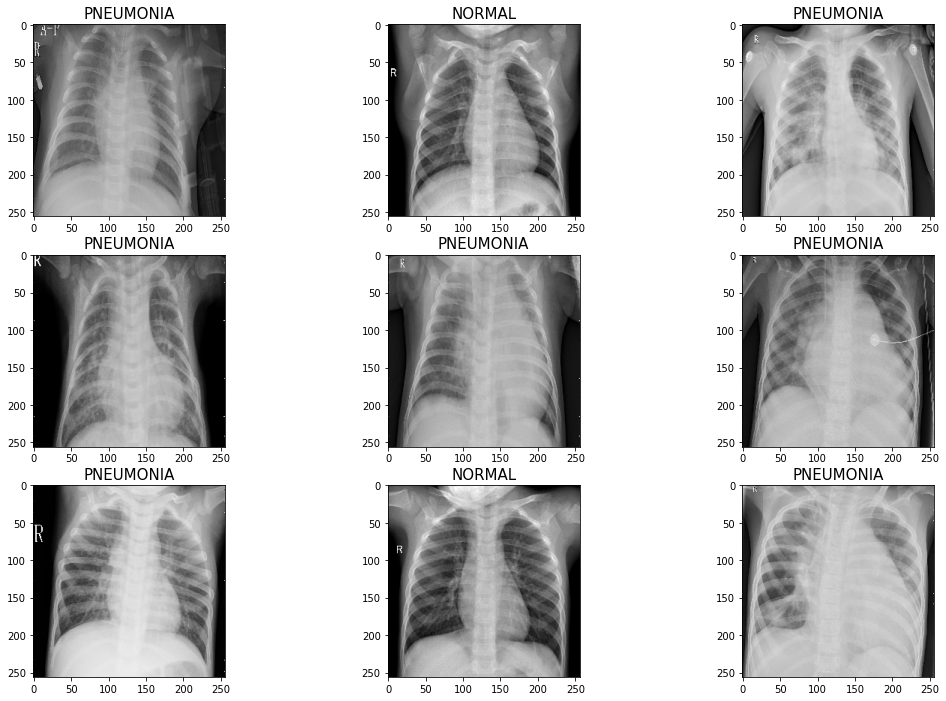

In [12]:
#visualize images
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (18,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i])
    plt.title(categories[int(train_labels[i])], fontsize = 15)
    
plt.savefig('images/chest_xrays.png')
    
plt.show()

Since Pneumonia is known to inflame both lungs, I predicted the cloudier images are from Pneumonia patients. https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia says white spots in the lungs is how doctors find an infection from an chest x-ray. 

# Model One - Feedforward Neural Network

In [13]:
num_classes = 1

# specifying the model structure
model = Sequential()

#matching shape sizes
print(y_train.shape)
print(X_train.shape)

# specify the first hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# specify the second layer
model.add(Dense(64))
model.add(Dropout(0.2))

# specify the output layer
model.add(Dense(num_classes, activation='sigmoid'))

# model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc', 'Recall', 'Precision'])

#history necessary for summary and evaluation
history = model.fit(X_train.flatten()[:len(y_train)], y_train,
                    batch_size= 1,
                    epochs=4,
                    verbose=1,
                    validation_data=(X_val.flatten()[:len(y_val)], y_val.flatten()),
                    class_weight = class_weights)
score = model.evaluate(X_test.flatten()[:len(y_test)], y_test.flatten(), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(600,)
(600, 256, 256, 3)
Epoch 1/4
600/600 [==============================] - 2s 1ms/step - loss: 0.7163 - acc: 0.3759 - recall: 0.2300 - precision: 0.6865 - val_loss: 0.6935 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/4
600/600 [==============================] - 0s 739us/step - loss: 0.6520 - acc: 0.7140 - recall: 0.8510 - precision: 0.7876 - val_loss: 0.6933 - val_acc: 0.5625 - val_recall: 0.8750 - val_precision: 0.5385
Epoch 3/4
600/600 [==============================] - 0s 741us/step - loss: 0.6864 - acc: 0.5135 - recall: 0.5348 - precision: 0.7405 - val_loss: 0.6941 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 4/4
600/600 [==============================] - 0s 809us/step - loss: 0.6968 - acc: 0.6239 - recall: 0.7490 - precision: 0.7446 - val_loss: 0.6935 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Test loss: 0.6917406916618347
Test accuracy: 0.5192307829856873


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
results_train = model.evaluate(X_train.flatten()[:len(y_train)], y_train)
results_test = model.evaluate(X_test.flatten()[:len(y_test)], y_test.flatten())
print(results_train, results_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.6917 - acc: 0.5192 - recall: 0.6308 - precision: 0.6119
[0.6941887140274048, 0.5199999809265137, 0.4966442883014679, 0.7789473533630371] [0.6917406916618347, 0.5192307829856873, 0.6307692527770996, 0.611940324306488]


# Evaluation Metrics - Model One

In [16]:
data_train.class_indices
data_val.class_indices
data_test.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
#confusion matrix
pred = model.predict(X_test.flatten()[:len(y_test)])
cm = confusion_matrix(y_test.flatten(), pred.round())
cm

array([[ 78, 156],
       [144, 246]], dtype=int64)

In [18]:
classification_report(y_test.flatten(), pred.round())

'              precision    recall  f1-score   support\n\n         0.0       0.35      0.33      0.34       234\n         1.0       0.61      0.63      0.62       390\n\n    accuracy                           0.52       624\n   macro avg       0.48      0.48      0.48       624\nweighted avg       0.51      0.52      0.52       624\n'

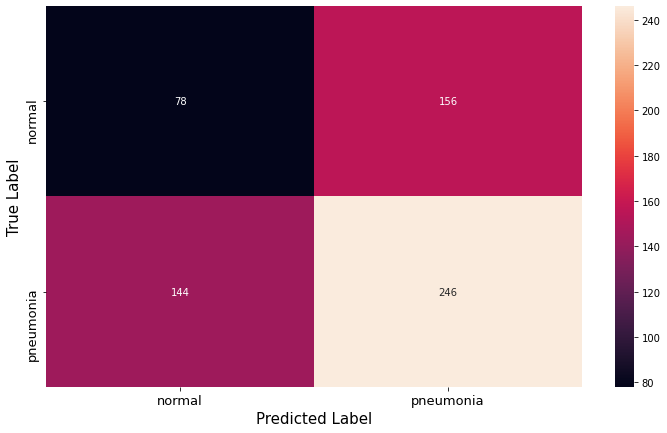

In [19]:
fig = plt.figure(figsize = (12,7))
heat = sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])
heat.tick_params(labelsize = 13)
plt.xlabel('Predicted Label', fontsize = 15)
plt.ylabel('True Label', fontsize = 15)

plt.savefig('images/model1cm.png')

plt.show()

This generic model has 78 true normal images, 246 true pneumonia images, 144 false negatives (patient has pneumonia and the model didn't catch it), and 156 false positives (patient does not have pneumonia but the model says they are ill). This model is very weak. There are a ton of false negatives and false positives.

# Model Two - CNN

In [20]:
tic = time.time()
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn2.add(layers.MaxPooling2D((2, 2),padding='same'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn2.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision', 'AUC'])

history = cnn2.fit(X_train,
                y_train,
                batch_size=25,
                epochs=5,
                class_weight = class_weights,
                validation_data=(X_val, y_val))
toc = time.time()
print('run time:', toc-tic)

Epoch 1/5
24/24 [==============================] - 44s 2s/step - loss: 6.9402 - acc: 0.5230 - recall: 0.4935 - precision: 0.8001 - auc: 0.5516 - val_loss: 0.6082 - val_acc: 0.8125 - val_recall: 1.0000 - val_precision: 0.7273 - val_auc: 0.9062
Epoch 2/5
24/24 [==============================] - 43s 2s/step - loss: 0.9787 - acc: 0.6862 - recall: 0.6537 - precision: 0.8799 - auc: 0.7092 - val_loss: 1.8693 - val_acc: 0.5625 - val_recall: 0.1250 - val_precision: 1.0000 - val_auc: 0.7734
Epoch 3/5
24/24 [==============================] - 45s 2s/step - loss: 0.6929 - acc: 0.7409 - recall: 0.7190 - precision: 0.8982 - auc: 0.8230 - val_loss: 0.3619 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000 - val_auc: 0.9531
Epoch 4/5
24/24 [==============================] - 42s 2s/step - loss: 0.3326 - acc: 0.8337 - recall: 0.8360 - precision: 0.9400 - auc: 0.9234 - val_loss: 0.7436 - val_acc: 0.7500 - val_recall: 1.0000 - val_precision: 0.6667 - val_auc: 0.9062
Epoch 5/5
24/24 [===========

In [21]:
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

In [22]:
results_train = cnn2.evaluate(data_train)
results_test = cnn2.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 17s 17s/step - loss: 0.5149 - acc: 0.8446 - recall: 0.8974 - precision: 0.8600 - auc: 0.8900
[0.3515245020389557, 0.847967803478241, 0.8237419128417969, 0.9666868448257446, 0.9414424896240234] [0.5148676633834839, 0.8445512652397156, 0.8974359035491943, 0.859950840473175, 0.8899682760238647]


## Evaluation Metrics - Model Two

In [23]:
#confusion matrix
pred2 = cnn2.predict(X_test)
cm = confusion_matrix(y_test, pred2.round())
cm

array([[177,  57],
       [ 40, 350]], dtype=int64)

In [24]:
classification_report(y_test, pred2.round())

'              precision    recall  f1-score   support\n\n         0.0       0.82      0.76      0.78       234\n         1.0       0.86      0.90      0.88       390\n\n    accuracy                           0.84       624\n   macro avg       0.84      0.83      0.83       624\nweighted avg       0.84      0.84      0.84       624\n'

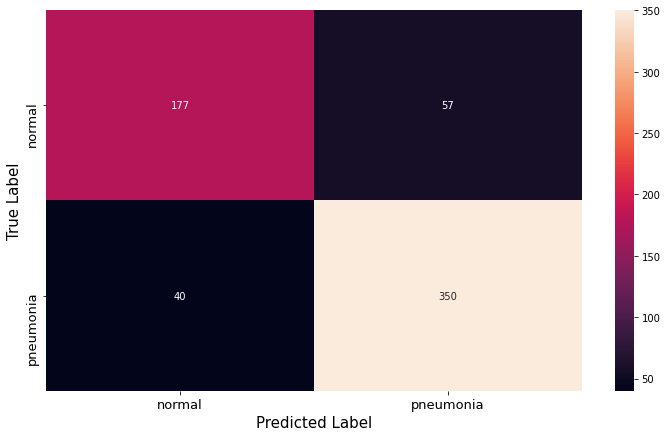

In [25]:
fig = plt.figure(figsize = (12,7))
heat = sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])
heat.tick_params(labelsize = 13)
plt.xlabel('Predicted Label', fontsize = 15)
plt.ylabel('True Label', fontsize = 15)

plt.savefig('images/model2cm.png')

plt.show()

Model 2 has 177 true normal images, 350 true pneumonia images, 40 false negatives (patient has pneumonia and the model didn't catch it), and 57 false positives (patient does not have pneumonia but the model says they are ill).

# Model Three - CNN

In [26]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same', strides=2)) #3 x 3 shape of filter, 64 convolutions
cnn3.add(layers.MaxPooling2D((2, 2),padding='same', strides=2)) #padding added so edge pixels get included in convolution
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', strides=2)) #hidden layer
cnn3.add(layers.MaxPooling2D((2, 2),padding='same', strides=2)) #max pooling
cnn3.add(layers.Flatten()) #flatten layer
cnn3.add(layers.Dense(32, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.007),#compiling with gradient descent
              metrics=['acc', 'Recall', 'Precision']) #compiling important metrics

history = cnn3.fit(X_train,
                y_train,
                epochs=5,
                batch_size=25,
                class_weight = class_weights,
                validation_data=(X_val, y_val))

Epoch 1/5
24/24 [==============================] - 7s 276ms/step - loss: 0.9768 - acc: 0.6022 - recall: 0.6583 - precision: 0.7707 - val_loss: 0.5654 - val_acc: 0.6875 - val_recall: 0.6250 - val_precision: 0.7143
Epoch 2/5
24/24 [==============================] - 7s 307ms/step - loss: 0.5357 - acc: 0.7691 - recall: 0.7523 - precision: 0.9262 - val_loss: 0.6804 - val_acc: 0.5625 - val_recall: 1.0000 - val_precision: 0.5333
Epoch 3/5
24/24 [==============================] - 7s 309ms/step - loss: 0.3587 - acc: 0.8763 - recall: 0.8723 - precision: 0.9541 - val_loss: 0.2529 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000
Epoch 4/5
24/24 [==============================] - 7s 307ms/step - loss: 0.2483 - acc: 0.8916 - recall: 0.8799 - precision: 0.9723 - val_loss: 0.2472 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000
Epoch 5/5
24/24 [==============================] - 7s 306ms/step - loss: 0.2108 - acc: 0.9077 - recall: 0.8980 - precision: 0.9764 - val_loss: 0.075

In [27]:
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [28]:
results_train = cnn3.evaluate(data_train)
results_test = cnn3.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 8s 8s/step - loss: 0.3848 - acc: 0.8718 - recall: 0.9077 - precision: 0.8894
[0.27623382210731506, 0.8882285356521606, 0.8606451749801636, 0.9872705936431885] [0.38475102186203003, 0.8717948794364929, 0.9076923131942749, 0.8894472122192383]


## Evaluation Metrics - Model 3

In [29]:
#confusion matrix
pred = cnn3.predict(X_test)
cm = confusion_matrix(y_test, pred.round())
cm

array([[190,  44],
       [ 36, 354]], dtype=int64)

In [30]:
classification_report(y_test, pred.round())

'              precision    recall  f1-score   support\n\n         0.0       0.84      0.81      0.83       234\n         1.0       0.89      0.91      0.90       390\n\n    accuracy                           0.87       624\n   macro avg       0.87      0.86      0.86       624\nweighted avg       0.87      0.87      0.87       624\n'

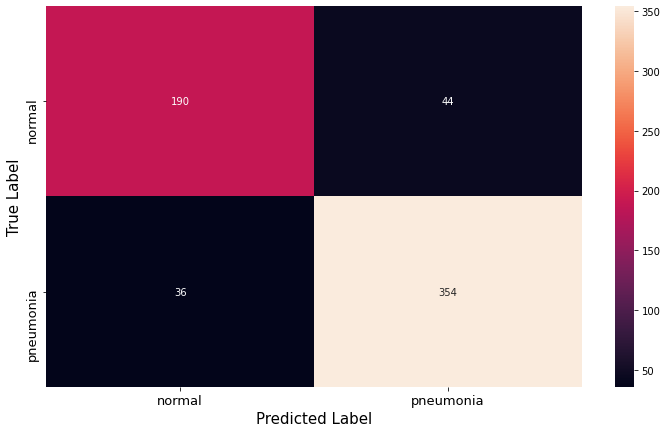

In [31]:
fig = plt.figure(figsize = (12,7))
heat = sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])
heat.tick_params(labelsize = 13)
plt.xlabel('Predicted Label', fontsize = 15)
plt.ylabel('True Label', fontsize = 15)

plt.savefig('images/model3cm.png')

plt.show()

Model 3 has 190 true normal images, 354 true pneumonia images, 36 false negatives (patient has pneumonia and the model didn't catch it), and 44 false positives (patient does not have pneumonia but the model says they are ill).

# Model 4 - CNN

In [32]:
tic = time.time()
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn4.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
cnn4.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn4.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision'])

In [33]:
history = cnn4.fit(X_train,
                    y_train,
                    epochs=9,
                    batch_size=25,
                    class_weight = class_weights,
                    validation_data=(X_val, y_val))
toc = time.time()
print('run time:', toc-tic)

Epoch 1/9
24/24 [==============================] - 45s 2s/step - loss: 1.9952 - acc: 0.5161 - recall: 0.5776 - precision: 0.7149 - val_loss: 0.6630 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/9
24/24 [==============================] - 41s 2s/step - loss: 0.6522 - acc: 0.6804 - recall: 0.7916 - precision: 0.7828 - val_loss: 0.6324 - val_acc: 0.6250 - val_recall: 1.0000 - val_precision: 0.5714
Epoch 3/9
24/24 [==============================] - 39s 2s/step - loss: 0.4481 - acc: 0.8129 - recall: 0.8333 - precision: 0.9146 - val_loss: 0.3888 - val_acc: 0.7500 - val_recall: 0.7500 - val_precision: 0.7500
Epoch 4/9
24/24 [==============================] - 39s 2s/step - loss: 0.2869 - acc: 0.8801 - recall: 0.8765 - precision: 0.9613 - val_loss: 0.4139 - val_acc: 0.7500 - val_recall: 1.0000 - val_precision: 0.6667
Epoch 5/9
24/24 [==============================] - 40s 2s/step - loss: 0.1886 - acc: 0.9299 - recall: 0.9329 - precision: 0.9722 - val_loss: 0.3362 - val_ac

In [34]:
cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
average_pooling2d_1 (Average (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
average_pooling2d_2 (Average (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [35]:
results_train = cnn4.evaluate(data_train)
results_test = cnn4.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 19s 19s/step - loss: 2.0275 - acc: 0.6490 - recall: 1.0000 - precision: 0.6404
[0.4454987347126007, 0.860237717628479, 0.9976774454116821, 0.8430004119873047] [2.02748441696167, 0.6490384340286255, 1.0, 0.6403940916061401]


## Evaluation Metrics - Model 4 

In [36]:
pred4 = cnn4.predict(X_test)
cm = confusion_matrix(y_test, pred4.round())
cm

array([[ 15, 219],
       [  0, 390]], dtype=int64)

In [37]:
classification_report(y_test, pred4.round())

'              precision    recall  f1-score   support\n\n         0.0       1.00      0.06      0.12       234\n         1.0       0.64      1.00      0.78       390\n\n    accuracy                           0.65       624\n   macro avg       0.82      0.53      0.45       624\nweighted avg       0.78      0.65      0.53       624\n'

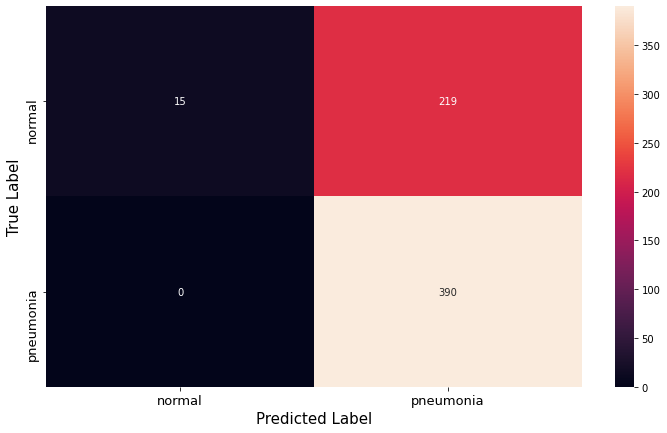

In [38]:
fig = plt.figure(figsize = (12,7))
heat = sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])
heat.tick_params(labelsize = 13)
plt.xlabel('Predicted Label', fontsize = 15)
plt.ylabel('True Label', fontsize = 15)

plt.savefig('images/model4cm.png')

plt.show()

Model 4 has 15 true normal images, 390 true pneumonia images, 0 false negatives (patient has pneumonia and the model didn't catch it), and 219 false positives (patient does not have pneumonia but the model says they are ill). This is the strongest model, but far from perfect.

# Model 5 - InceptionV3

In [39]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
inception_model = models.Sequential()
inception_model.add(imagenet)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(Dense(1024,activation='relu'))
inception_model.add(Dense(1024,activation='relu')) #dense layer 2
inception_model.add(Dense(512,activation='relu')) #dense layer 3
inception_model.add(Dense(1,activation='sigmoid')) #final layer with sigmoid activation

In [40]:
inception_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

history = inception_model.fit(X_train, y_train,
          epochs=6,
          batch_size=32,
        class_weight = class_weights,
          validation_data=(X_val, y_val))

Epoch 1/6
19/19 [==============================] - 267s 14s/step - loss: 0.5756 - accuracy: 0.7557 - recall: 0.7294 - precision: 0.9222 - auc: 0.8387 - val_loss: 2.8382 - val_accuracy: 0.5625 - val_recall: 1.0000 - val_precision: 0.5333 - val_auc: 0.6875
Epoch 2/6
19/19 [==============================] - 262s 14s/step - loss: 0.2084 - accuracy: 0.9451 - recall: 0.9362 - precision: 0.9892 - auc: 0.9771 - val_loss: 5.4651 - val_accuracy: 0.7500 - val_recall: 1.0000 - val_precision: 0.6667 - val_auc: 0.7500
Epoch 3/6
19/19 [==============================] - 277s 14s/step - loss: 0.0794 - accuracy: 0.9905 - recall: 0.9930 - precision: 0.9940 - auc: 0.9981 - val_loss: 3.2407 - val_accuracy: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000 - val_auc: 0.8750
Epoch 4/6
19/19 [==============================] - 264s 14s/step - loss: 0.1324 - accuracy: 0.9371 - recall: 0.9317 - precision: 0.9809 - auc: 0.9905 - val_loss: 11.7489 - val_accuracy: 0.5000 - val_recall: 0.0000e+00 - val_precision: 

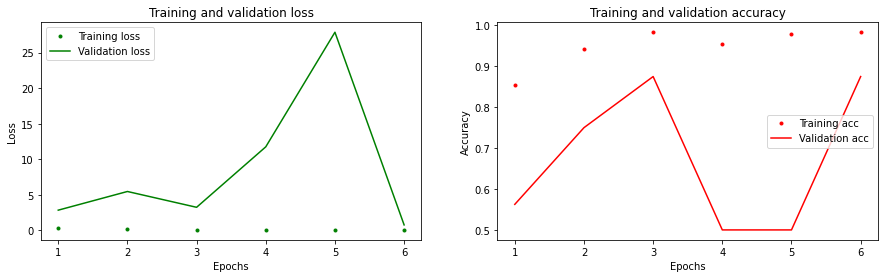

In [41]:
hist_cnn = history.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']

epochs = range(1, 7) #6 epochs plus 1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
inception_model.evaluate(X_train)

19/19 [==============================] - 3s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0]

## Evaluation Metrics - Model 5

In [43]:
#confusion matrix
pred5 = inception_model.predict(X_test)
cm = confusion_matrix(y_test, pred5.round())
cm

array([[199,  35],
       [ 67, 323]], dtype=int64)

In [44]:
classification_report(y_test, pred5.round())

'              precision    recall  f1-score   support\n\n         0.0       0.75      0.85      0.80       234\n         1.0       0.90      0.83      0.86       390\n\n    accuracy                           0.84       624\n   macro avg       0.83      0.84      0.83       624\nweighted avg       0.84      0.84      0.84       624\n'

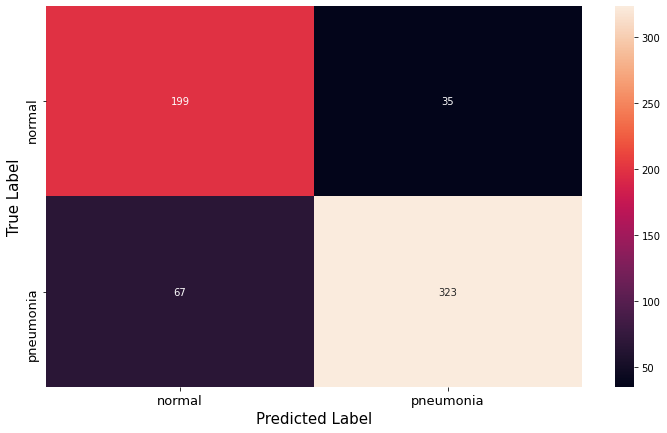

In [45]:
fig = plt.figure(figsize = (12,7))
heat = sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])
heat.tick_params(labelsize = 13)
plt.xlabel('Predicted Label', fontsize = 15)
plt.ylabel('True Label', fontsize = 15)

plt.savefig('images/model5cm.png')

plt.show()

Model 5 has 199 true normal images. It also has 323 true pneumonia images, 67 false negatives, and 35 false positives (patient does not have pneumonia but the model says they are ill).

# Summary/Business Recommendation

My recommendations would be to add in many epochs, use a small learning rate, and use the adam optimizer. Average pooling and max pooling both worked well. To incorporate the corner pixels of a picture, add padding in to the model. Observing recall, precision, and accuracy will determine which model is the best. The equation for recall is true positive over true positives plus false negatives. High recall means there aren't many false negative. A false negative would be bad because one would go without treatment for their illness. A false positive could be bad because one might get treated for an illness they don't have. In this case I believe a false negative would be worse because a patient wouldn't get the care they need. Model 4 seems to be the best model becuase the normal and pneumonia split seems to resemble the split of the images and there's only 6 false negatives.

# Futher Steps and Analysis

With more time a super computer I could explore the data further. I could create more models, add more epochs within the model, and use a small learning rate. The best asset would be a computer with hardware dedicated to running complex models. The faster the model runs foward and backward propogate, the faster I can get the recall, precsion, and accuracy of every model. Thus, I would have more time to create more models. To create the most accurate model I'd need the largest sample size possible (more pneumonia images and images of lungs without pneumonia). I would sepearate out a dataset for smokers and nonsmokers. I'd also look into if pneumonia lungs get mixed up with bronchitis lungs. Faulty images could also negatively effect the model. 